In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine

from tqdm.notebook import tqdm

from copy import copy
from my_funcs import get_dataframe


### Метрика TPR@FPR

Для того, чтобы измерить принадлежность векторов к имеющемуся домены голосов, можно использовать следующую метрику. Обычно она используется для моделей, которые обучаются создавать векторные представления чего-либо, но в моём случае, её можно использовать на выходах из алгоритма получения мел-кепстральных коэффициентов. Я буду использовать только их, в то время как классификатор обучен на более широком наборе признаков, так как они лучше всего отражают специфику аудио сигнала.

### Алгоритм реализации метрики

Необходимо создать два набора векторных представлений аудио: query и distractors. 
Никакие аудио из этих наборов не должны содержаться в обучающем и валидационном датасете.

In [4]:
df = pd.read_pickle("experiments/crowd_train_all_data_embedded.pkl")

In [5]:
query = get_dataframe(df, 0, 13, max_filter=18)
query.shape[0]

408


3551

In [6]:
distractors = get_dataframe(df, 20, 18, max_filter=30)
distractors.shape[0]

196


3528

Посчитаю косинусные расстояния между векторами, соответствующими одним и тем же людям из query части.

In [7]:
between_one_class_in_query = []
for s_id in tqdm(set(query.source_id)):
    temp_arr = query[query.source_id == s_id].audio_feature.to_numpy()
    for i in range(len(temp_arr)):
        for j in range(i + 1, len(temp_arr)):
            between_one_class_in_query.append(cosine(temp_arr[i][36 + 384: 36 + 384 + 60], temp_arr[j][36 + 384: 36 + 384 + 60]))

  0%|          | 0/408 [00:00<?, ?it/s]

Посчитаю косинусные расстояния между векторами, соответствующими разным людям из query части.

In [8]:
between_diff_class_in_query = []
visited = []

for s_id in tqdm(set(query.source_id)):
    visited.append(s_id)
    temp_arr_selected_class = query[query.source_id == s_id].audio_feature.to_numpy()
    temp_arr_other_class = query[~query.source_id.isin(visited)].audio_feature.to_numpy()

    for selected_emb in temp_arr_selected_class:
        for other_emb in temp_arr_other_class:
            between_diff_class_in_query.append(cosine(selected_emb[36 + 384: 36 + 384 + 60], other_emb[36 + 384: 36 + 384 + 60]))

  0%|          | 0/408 [00:00<?, ?it/s]

Посчитаю косинусные расстояния между всеми парами из query и distractors. Всего получится |query|*|distractors| пар.

In [9]:
between_query_distractors = []

for i in tqdm(query.audio_feature.to_numpy()):
    for j in distractors.audio_feature.to_numpy():
        between_query_distractors.append(cosine(i[36 + 384: 36 + 384 + 60], j[36 + 384: 36 + 384 + 60]))

  0%|          | 0/3551 [00:00<?, ?it/s]

Сложу количества пар, полученных на 2 и 3 шагах. Это количество false пар.

In [10]:
false_pairs = copy(between_diff_class_in_query)

In [11]:
false_pairs.extend(between_query_distractors)

Зафиксируем FPR (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.

In [33]:
FPR = 0.01
N = round(FPR * len(false_pairs))
N

188150

Отсортирую все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксирую как пороговое расстояние.

In [13]:
false_pairs.sort()

In [34]:
threshold = false_pairs[N]
threshold

0.0048326071016201455

Посчитаю количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделю это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение метрики.

In [31]:
positive_pairs = np.array(between_one_class_in_query)

In [35]:
len(positive_pairs[positive_pairs < threshold])/len(positive_pairs)

0.4184032136580467

Нарисую визуализацию, чтобы подобрать устраивающий меня False Positive Rate

In [44]:
FPRs = np.linspace(0, 1, 1_000)[:-1]
TPRs = []

for FPR in FPRs:
    N = round(FPR * len(false_pairs))
    threshold = false_pairs[N]
    TPRs.append(len(positive_pairs[positive_pairs < threshold])/len(positive_pairs))

[]

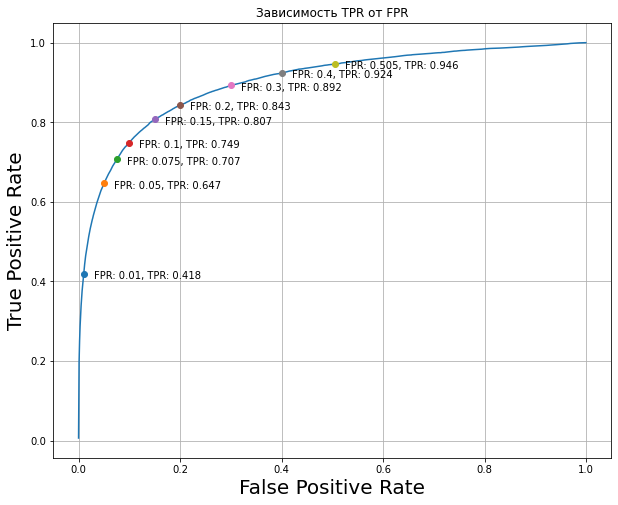

In [45]:
plt.figure(figsize=(10, 8))
plt.title('Зависимость TPR от FPR')
plt.grid()
plt.plot(FPRs, TPRs)
for fprate in [0.01, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.505]:
    indx = np.where(np.round(FPRs, 3) == fprate)[0].item()
    plt.scatter(FPRs[indx], TPRs[indx], zorder=3)
    plt.annotate(f'FPR: {round(FPRs[indx], 3)}, TPR: {round(TPRs[indx], 3)}', (FPRs[indx], TPRs[indx]), 
            textcoords='offset points', xytext=(10, -5))
plt.xlabel('False Positive Rate', size=20)
plt.ylabel('True Positive Rate', size=20)
plt.plot()

Подбор FPR зависит от уровня безопасности, которого мы хотим достигнуть в нашей идентификационной системе. Уменьшая FPR получаем более низкий порог, которой уменьшает как количество ложных срабатываний, так и количество верных срабатывания системы. Таким образом, оптимальным fpr = 0.075, так как он поддерживает адекватный уровень tpr.

In [43]:
import json
model_name = 'catboost tuned'

with open(f'cross_validation_scores/{model_name}_threshold.json', 'r') as f:
    d = json.load(f)

d

{'threshold': 0.2896592301118485}

In [47]:
FPR = 0.075
N = round(FPR * len(false_pairs))
threshold = false_pairs[N]
threshold

0.008504369429957692

In [48]:
d['tpr@fpr_threshold'] = threshold
d

{'threshold': 0.2896592301118485, 'tpr@fpr_threshold': 0.008504369429957692}

In [49]:
import json

with open(f'cross_validation_scores/{model_name}_threshold.json', 'w') as f:
    json.dump(d, f)